In [0]:
from PIL import Image 
import glob, random 
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

from google.colab import files
files.upload()

Saving SPAI_lens_dataset.zip to SPAI_lens_dataset.zip


{'SPAI_lens_dataset.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x004b\xd4N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x17\x00\x00\x00SPAI_lens_dataset/test/PK\x03\x04\x14\x00\x00\x00\x00\x00\x19b\xd4N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x19\x00\x00\x00SPAI_lens_dataset/test/A/PK\x03\x04\x14\x00\x00\x00\x00\x00\x92`\xd4N\x1f\xd8\xd0\xbc\x9d!\x00\x00\x9d!\x00\x00\x1f\x00\x00\x00SPAI_lens_dataset/test/A/80.png\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00@\x00\x00\x00@\x08\x02\x00\x00\x00%\x0b\xe6\x89\x00\x00 \x00IDATh\x05]\xc1\xd9\x8f\x9e\xe7y\x1f\xe0\xdf\xfdl\xef\xfa\xed\xb3rf\xc8!\xa9\x9dZ,\xdbR\x9c\xc4.\x92\xb4\xf1A\x9a\xb6h\x81"\x01\x8a\x9e\xf6\xa4\xffX\x0f\xd2\x93\x16\tP\xa0)\xdc\xc4\xd9,\xcb\xb2\xa5\x98\xd4BR$\x873\x9c\x99o\xff\xbew\x7f\x96\xbb\x94\x9dn\xb9.\x92\x80\xef\x01\x0c(`\r\xec\x01s\xc0\xed\x03W\xf85\x01\xf0.\x98\x81\x02\x86e\x07\x81\xd6\x82 \x14\xa4\x85\x05\x8cFg\x81\x1c\xd0Z.\xbd\x07\x08!\x85,w\x19\xd3\x00@\x03\xb6\x0f\xec\xc9x\xc6\x84\xe0\x18\xd6C0\xfa\r\x84

In [0]:
! unzip SPAI_lens_dataset.zip

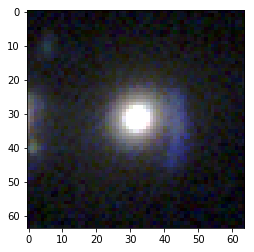

In [0]:
smpl_img = Image.open("SPAI_lens_dataset/train/A/33.png")
plt.imshow(smpl_img)


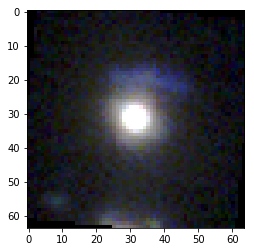

In [0]:
RR = transforms.RandomRotation((0, 360))

TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()
myTransforms = transforms.Compose([RR, TT])

img_R = myTransforms(smpl_img)
plt.imshow(TPIL(img_R))

In [0]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.transforms = transforms
    path_A = root +'A'
    self.files_A = glob.glob(path_A + '/*.*')
    path_B = root +'B'
    self.files_B = glob.glob(path_B + '/*.*')
    
  def __getitem__(self, index):
    rand_A_file = self.files_A[random.randint(0, len(self.files_A)-1)] #Select random lens image file
    rand_A_im = Image.open(rand_A_file) #Open random lens image file
    tr_A = self.transforms(rand_A_im) #Transform random lens image
    
    rand_B_file = self.files_B[random.randint(0, len(self.files_B)-1)]
    rand_B_im = Image.open(rand_B_file)
    tr_B = self.transforms(rand_B_im)                           

    return {'A':tr_A, 'B':tr_B, 'A_label':1.0, 'B_label':0.0}
  
  def __len__(self):
    return 150

In [0]:
# Prepare the data

data_path = 'SPAI_lens_dataset/'
train_dataloader = torch.utils.data.DataLoader(ImageDataset(data_path+'train/',
                                                           transforms=myTransforms),
                                              batch_size=32,
                                              shuffle=True)

test_dataloader = torch.utils.data.DataLoader(ImageDataset(data_path+'test/',
                                                           transforms=myTransforms),
                                              batch_size=32,
                                              shuffle=True)

In [0]:
print('Number of Batches:', len(train_dataloader))

smpl_batch = next(iter(train_dataloader))

print('A Data shape: ', smpl_batch['A'].shape)
print(smpl_batch['A_label'])
print('B Data shape: ', smpl_batch['B'].shape)
print(smpl_batch['B_label'])

Number of Batches: 5
A Data shape:  torch.Size([32, 3, 64, 64])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)
B Data shape:  torch.Size([32, 3, 64, 64])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


In [0]:
class CNN(torch.nn.Module):
  def __init__(self, nc, nfm, img_size):
    super(CNN, self).__init__()
    
    exp = int( math.log(img_size)/math.log(2) )
    
    self.cnn = [nn.Conv2d(nc, nfm, 4, 2, 1),
               nn.BatchNorm2d(nfm),
               nn.ReLU()]
    
    for i in range(exp-3):
      self.cnn += [nn.Conv2d( nfm*(2**i) , nfm*( 2**(i+1) ), 4, 2, 1),
                  nn.BatchNorm2d(nfm*( 2**(i+1) )),
                  nn.ReLU()]
      
    self.cnn += [nn.Conv2d( nfm*( 2**(exp-3) ) , 1, 4, 1, 0),
                nn.Sigmoid()]
    
    self.cnn = nn.Sequential(*self.cnn)
    
  def forward(self, inputs):
    return self.cnn(inputs)
    

class ConvolutionalNeuralNetwork(torch.nn.Module):
  def __init__(self, nc, nfm):
    super(ConvolutionalNeuralNetwork, self).__init__()
    self.cnn = nn.Sequential(# input: nc x 64 x 64,
                            nn.Conv2d(nc, nfm, 4, 2, 1),
                            # After 1st layer: nfm x 32 x 32)
                            nn.BatchNorm2d(nfm),
                            nn.ReLU(),
                            nn.Conv2d(nfm, nfm*2, 4, 2, 1),
                            # After 2nd layer: nfm*2 x 16 x 16)
                            nn.BatchNorm2d(nfm*2),
                            nn.ReLU(),
                            nn.Conv2d(nfm*2, nfm*4, 4, 2, 1),
                            # After 3rd layer: nfm*4 x 8 x 8)
                            nn.BatchNorm2d(nfm*4),
                            nn.ReLU(),    
                            nn.Conv2d(nfm*4, nfm*8, 4, 2, 1),
                            # After 4th layer: nfm*8 x 4 x 4)
                            nn.BatchNorm2d(nfm*8),
                            nn.ReLU(), 
                            nn.Conv2d(nfm*8, 1, 4, 1, 0),
                            # After 5th layer: 1 x 1 x 1)
                            nn.Sigmoid()
                            )
  def forward(self, inputs):
    return self.cnn(inputs)

class Full_Conn_NN(torch.nn.Module):
  def __init__(self):
    super(Full_Conn_NN, self).__init__()
    self.fcnn = nn.Sequential(
                            nn.Linear(64*64*3, int(64/2)*64*3),
                            nn.BatchNorm1d( int(64/2)*64*3 ),
                            nn.ReLU(),
                            nn.Linear(int(64/2)*64*3, int(64/4)*64*3),
                            nn.BatchNorm1d( int(64/4)*64*3 ),
                            nn.ReLU(),
                            nn.Linear(int(64/4)*64*3, int(64/8)*64*3),
                            nn.BatchNorm1d( int(64/8)*64*3 ),
                            nn.ReLU(),
                            nn.Linear(int(64/8)*64*3, int(64/16)*64*3),
                            nn.BatchNorm1d( int(64/16)*64*3 ),
                            nn.ReLU(),
                            nn.Linear(int(64/16)*64*3, int(64/32)*64*3),
                            nn.BatchNorm1d( int(64/32)*64*3 ),
                            nn.ReLU(),
                            nn.Linear(int(64/32)*64*3, int(64/64)*64*3),
                            nn.BatchNorm1d( int(64/64)*64*3 ),
                            nn.ReLU(),
                            nn.Linear(int(64/64)*64*3, 1) ,
                            nn.Sigmoid()
                            )
  def forward(self, inputs):
    flat_inp = inputs.view(-1, 3*64*64)
    res = self.fcnn(flat_inp)
    return res
  

class C_FC_NN(torch.nn.Module):
  def __init__(self, nc, nfm):
    super(C_FC_NN, self).__init__()
    self.cnn = nn.Sequential(# input: nc x 64 x 64,
                            nn.Conv2d(nc, nfm, 5, 1, 0),
                            # After 1st Conv layer: nfm x 60 x 60)
                            nn.MaxPool2d(2, 2, 0),
                            # After 1st MaxPool layer: nfm x 30 x 30)
                            nn.ReLU(),
                            nn.Conv2d(nfm, nfm*2, 5, 1, 0),
                            # After 2nd Conv layer: nfm*2 x 26 x 26)
                            nn.MaxPool2d(2, 2, 0),
                            # After 2nd MaxPool layer: nfm x 13 x 13)
                            nn.ReLU(),
                            nn.Conv2d(nfm*2, nfm*4, 4, 1, 0),
                            # After 3rd Conv layer: nfm*4 x 10 x 10)
                            nn.MaxPool2d(2, 2, 0),
                            # After 3rd MaxPool layer: nfm*4 x 5 x 5)
                            nn.ReLU()
                            )
    self.fcl = nn.Sequential(nn.Linear(nfm*4*5*5, 1),
                             nn.Sigmoid()
                            )
    
  def forward(self, inputs):
    x = self.cnn(inputs)
    x_flat = x.view(-1, 64*4*5*5)
    res = self.fcl(x_flat)
    return res

In [0]:
# Test the Generalized CNN

# Prepare our data
data_path = 'SPAI_lens_dataset/'

# Test 64 x 64 Images
dl_64 = torch.utils.data.DataLoader(ImageDataset(data_path+'train/',
                                                           transforms=myTransforms),
                                              batch_size=1,
                                              shuffle=True)
batch_64=next(iter(dl_64))

# Test 256 x 256 Images
RS = transforms.Resize(256)
myTransforms = transforms.Compose([RR, RS, TT])
dl_256 = torch.utils.data.DataLoader(ImageDataset(data_path+'train/',
                                                           transforms=myTransforms),
                                              batch_size=1,
                                              shuffle=True)
batch_256=next(iter(dl_256))

# Test 512 x 512 Images
RS = transforms.Resize(512)
myTransforms = transforms.Compose([RR, RS, TT])
dl_512 = torch.utils.data.DataLoader(ImageDataset(data_path+'train/',
                                                           transforms=myTransforms),
                                              batch_size=1,
                                              shuffle=True)

batch_512=next(iter(dl_512))



nc = 3
nfm = 64 

CNN_64 = CNN(nc, nfm, 64)
results = CNN_64(batch_64['A'])
print('CNN on 64x64 Images: ', results.shape)

CNN_256 = CNN(nc, nfm, 256)
results = CNN_256(batch_256['A'])
print('CNN on 256x256 Images: ', results.shape)

CNN_512 = CNN(nc, nfm, 512)
results = CNN_512(batch_512['A'])
print('CNN on 512x512 Images: ', results.shape)




CNN on 64x64 Images:  torch.Size([1, 1, 1, 1])
CNN on 256x256 Images:  torch.Size([1, 1, 1, 1])
CNN on 512x512 Images:  torch.Size([1, 1, 1, 1])


In [0]:
nc = 3 #Number of Channels
nfm = 64 #Number of Discriminator Feature Maps
epochs = 100 # Number of training epochs

# Instantiating the Network
myCNN = ConvolutionalNeuralNetwork(nc, nfm)
myFCNN = Full_Conn_NN()
myCFCNN = C_FC_NN(nc, nfm)

# Optimizer 
CNN_optimizer = torch.optim.Adam(myCNN.parameters(), lr=0.0002)
FCNN_optimizer = torch.optim.Adam(myFCNN.parameters(), lr=0.0002)
CFCNN_optimizer = torch.optim.Adam(myCFCNN.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# Put CNN on GPU
if torch.cuda.is_available(): 
  myCNN = myCNN.cuda()
  myFCNN = myFCNN.cuda()
  myCFCNN = myCFCNN.cuda()

  


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0 , Train Loss: 5.06557559967041 , Test Loss: 2.7265965938568115
Epoch 1 , Train Loss: 1.8638797998428345 , Test Loss: 1.0583718866109848
Epoch 2 , Train Loss: 0.8660989254713058 , Test Loss: 1.0800964832305908
Epoch 3 , Train Loss: 0.48129747807979584 , Test Loss: 0.652513861656189
Epoch 4 , Train Loss: 0.3812921345233917 , Test Loss: 0.45881255343556404
Epoch 5 , Train Loss: 0.24976922944188118 , Test Loss: 0.41522839665412903
Epoch 6 , Train Loss: 0.21470493078231812 , Test Loss: 0.20637946762144566
Epoch 7 , Train Loss: 0.15702836588025093 , Test Loss: 0.2718927338719368
Epoch 8 , Train Loss: 0.10270769521594048 , Test Loss: 0.10965961404144764
Epoch 9 , Train Loss: 0.08891419786959887 , Test Loss: 0.20781541615724564
Epoch 10 , Train Loss: 0.06488157156854868 , Test Loss: 0.12071437388658524
Epoch 11 , Train Loss: 0.05308771785348654 , Test Loss: 0.08667507022619247
Epoch 12 , Train Loss: 0.05498455581255257 , Test Loss: 0.14882336556911469
Epoch 13 , Train Loss: 0.039921106

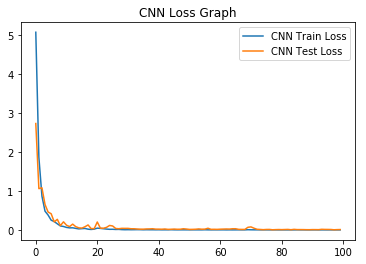

In [0]:
def train_test(network, optimizer, criterion, inp, mode): 
    optimizer.zero_grad()
    in_A = inp['A']
    in_B = inp['B']

    labels_A = inp['A_label'].float()
    labels_B = inp['B_label'].float()
    
    if torch.cuda.is_available(): 
        in_A, in_B = in_A.cuda(), in_B.cuda()
        labels_A, labels_B = labels_A.cuda(), labels_B.cuda()

    preds_A = network(in_A)
    error_A = criterion(preds_A, labels_A)

    preds_B = network(in_B)
    error_B = criterion(preds_B, labels_B)

    error = error_A + error_B
      
    if mode == 'train':
        error.backward()
        optimizer.step()

    return error.item()

# CONVOLUTIONAL NN TRAINING

CNN_losses = []
CNN_test_losses = []

# Train Network
for i in range(epochs):
    loss = 0
    test_loss = 0
    
    #Iterate through minibatches in training set
    for batch in train_dataloader:
        error = train_test(myCNN, CNN_optimizer, criterion, batch, 'train')
        loss += error
        
    CNN_losses.append(loss)
    
    #Iterate through minibatches in testing set
    for batch in test_dataloader:
        error  = train_test(myCNN, CNN_optimizer, criterion, batch, 'test')
        test_loss += error

    CNN_test_losses.append(test_loss)
    
    print("Epoch", i, ", Train Loss:", loss, ", Test Loss:", test_loss)

# Plot Loss Graph
plt.title('CNN Loss Graph')
plt.plot(CNN_losses, label='CNN Train Loss')
plt.plot(CNN_test_losses, label='CNN Test Loss')
plt.legend()
plt.show()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0 , Train Loss: 6.94881808757782 , Test Loss: 6.885530352592468
Epoch 1 , Train Loss: 6.845906734466553 , Test Loss: 6.858271956443787
Epoch 2 , Train Loss: 6.719521999359131 , Test Loss: 6.7824026346206665
Epoch 3 , Train Loss: 6.632331967353821 , Test Loss: 6.7683939933776855
Epoch 4 , Train Loss: 6.495850086212158 , Test Loss: 6.681074619293213
Epoch 5 , Train Loss: 6.442407846450806 , Test Loss: 6.657541275024414
Epoch 6 , Train Loss: 6.395755410194397 , Test Loss: 6.5693678855896
Epoch 7 , Train Loss: 6.267682909965515 , Test Loss: 6.550426006317139
Epoch 8 , Train Loss: 6.036452054977417 , Test Loss: 6.594107270240784
Epoch 9 , Train Loss: 5.926929950714111 , Test Loss: 6.342168807983398
Epoch 10 , Train Loss: 5.833763480186462 , Test Loss: 6.171101212501526
Epoch 11 , Train Loss: 5.7726733684539795 , Test Loss: 6.078060507774353
Epoch 12 , Train Loss: 5.685896039009094 , Test Loss: 6.155272722244263
Epoch 13 , Train Loss: 5.4753258228302 , Test Loss: 6.200759649276733
Epoc

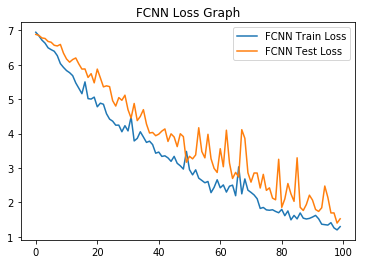

In [0]:
# FULLY CONNECTED NN TRAINING
FCNN_losses = []
FCNN_test_losses = []

# Train Network
for i in range(epochs):
    loss = 0
    test_loss = 0
    
    #Iterate through minibatches in training set
    for batch in train_dataloader:
        error = train_test(myFCNN, FCNN_optimizer, criterion, batch, 'train')
        loss += error
        
    FCNN_losses.append(loss)
    
    #Iterate through minibatches in testing set
    for batch in test_dataloader:
        error  = train_test(myFCNN, FCNN_optimizer, criterion, batch, 'test')
        test_loss += error

    FCNN_test_losses.append(test_loss)
    
    print("Epoch", i, ", Train Loss:", loss, ", Test Loss:", test_loss)

# Plot Loss Graph
plt.title('FCNN Loss Graph')
plt.plot(FCNN_losses, label='FCNN Train Loss')
plt.plot(FCNN_test_losses, label='FCNN Test Loss')
plt.legend()
plt.show()


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch 0 , Train Loss: 6.6774855852127075 , Test Loss: 6.168351054191589
Epoch 1 , Train Loss: 5.647609114646912 , Test Loss: 4.846889674663544
Epoch 2 , Train Loss: 4.203960478305817 , Test Loss: 3.2694143056869507
Epoch 3 , Train Loss: 3.464448392391205 , Test Loss: 2.482116311788559
Epoch 4 , Train Loss: 2.6480312943458557 , Test Loss: 2.2350423634052277
Epoch 5 , Train Loss: 2.2152786552906036 , Test Loss: 1.6172619760036469
Epoch 6 , Train Loss: 2.0125384628772736 , Test Loss: 1.5761951208114624
Epoch 7 , Train Loss: 2.343506008386612 , Test Loss: 2.3329548835754395
Epoch 8 , Train Loss: 1.952749878168106 , Test Loss: 1.178362101316452
Epoch 9 , Train Loss: 2.3468580693006516 , Test Loss: 1.5121133923530579
Epoch 10 , Train Loss: 1.4806757271289825 , Test Loss: 1.9787460267543793
Epoch 11 , Train Loss: 2.5497763454914093 , Test Loss: 1.0429658219218254
Epoch 12 , Train Loss: 1.7765619158744812 , Test Loss: 1.4630147218704224
Epoch 13 , Train Loss: 1.6691718995571136 , Test Loss: 1.

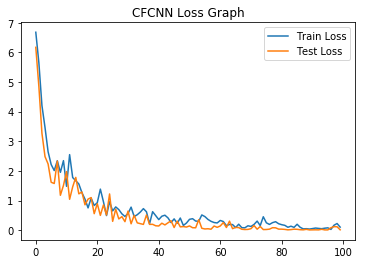

In [0]:
# CONVOLUTIONAL + FULLY CONNECTED LAYER NN TRAINING
CFCNN_losses = []
CFCNN_test_losses = []

# Train Network
for i in range(epochs):
    loss = 0
    test_loss = 0
    
    #Iterate through minibatches in training set
    for batch in train_dataloader:
        error = train_test(myCFCNN, CFCNN_optimizer, criterion, batch, 'train')
        loss += error
        
    CFCNN_losses.append(loss)
    
    #Iterate through minibatches in testing set
    for batch in test_dataloader:
        error  = train_test(myCFCNN, CFCNN_optimizer, criterion, batch, 'test')
        test_loss += error

    CFCNN_test_losses.append(test_loss)
    
    print("Epoch", i, ", Train Loss:", loss, ", Test Loss:", test_loss)

# Plot Loss Graph
plt.title('CFCNN Loss Graph')
plt.plot(CFCNN_losses, label='Train Loss')
plt.plot(CFCNN_test_losses, label='Test Loss')
plt.legend()
plt.show()

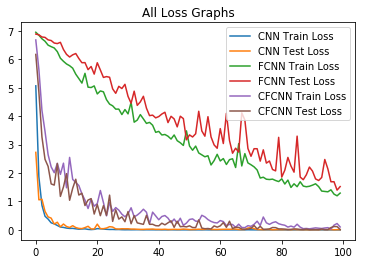

In [0]:
# Plot Loss Graph
plt.title('All Loss Graphs')
plt.plot(CNN_losses, label='CNN Train Loss')
plt.plot(CNN_test_losses, label='CNN Test Loss')
plt.plot(FCNN_losses, label='FCNN Train Loss')
plt.plot(FCNN_test_losses, label='FCNN Test Loss')
plt.plot(CFCNN_losses, label='CFCNN Train Loss')
plt.plot(CFCNN_test_losses, label='CFCNN Test Loss')
plt.legend()
plt.show()